<a href="https://colab.research.google.com/github/Gopi138942/Deeplearning_team_collabration/blob/main/Dlteamproject(4)_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader
from torch.nn import Parameter


# Define transformations
def get_transforms(dataset_name):
    if dataset_name == "MNIST":
        return transforms.Compose([
            transforms.Resize((32, 32)),  # Resize MNIST to 32x32 for consistency
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    elif dataset_name == "CIFAR":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])


# Load dataset
def load_dataset(dataset_name, batch_size=128):
    transform = get_transforms(dataset_name)
    dataset_class = torchvision.datasets.MNIST if dataset_name == "MNIST" else torchvision.datasets.CIFAR10

    train_set = dataset_class(root='./data', train=True, transform=transform, download=True)
    test_set = dataset_class(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [14]:


# Define AdaFace Loss
class AdaFace(nn.Module):
    def __init__(self, embedding_size=512, classnum=10, m=0.4, h=0.333, s=64.0, t_alpha=1.0):
        super(AdaFace, self).__init__()
        self.kernel = Parameter(torch.Tensor(embedding_size, classnum))
        self.kernel.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)  # Normalize and scale

        self.m, self.h, self.s = m, h, s
        self.eps, self.t_alpha = 1e-3, t_alpha

        self.register_buffer('batch_mean', torch.ones(1) * 20)
        self.register_buffer('batch_std', torch.ones(1) * 100)

    def forward(self, embeddings, norms, label):
        kernel_norm = nn.functional.normalize(self.kernel, p=2, dim=0)
        # Ensure cosine is 2D before scattering
        cosine = torch.mm(embeddings, kernel_norm).clamp(-1 + self.eps, 1 - self.eps)
        # If cosine is not 2D, reshape it:
        if cosine.dim() < 2:
            cosine = cosine.unsqueeze(0)
        # If the cosine Tensor is already 2D, keep it as it was


        safe_norms = torch.clip(norms, min=0.001, max=100).detach()

        with torch.no_grad():
            self.batch_mean = self.t_alpha * safe_norms.mean() + (1 - self.t_alpha) * self.batch_mean
            self.batch_std = self.t_alpha * safe_norms.std() + (1 - self.t_alpha) * self.batch_std

        margin_scaler = torch.clip(((safe_norms - self.batch_mean) / (self.batch_std + self.eps)) * self.h, -1, 1)

        # Ensure label shape is compatible with cosine for scattering:
        # Check if label needs unsqueezing for proper broadcasting
        if label.dim() == 0:
            label = label.unsqueeze(0)

        m_arc = torch.zeros_like(cosine).scatter_(1, label.unsqueeze(1), self.m * margin_scaler.unsqueeze(1) * -1)

        theta = cosine.acos()
        cosine = torch.clip(theta + m_arc, min=self.eps, max=math.pi - self.eps).cos()

        m_cos = torch.zeros_like(cosine).scatter_(1, label.unsqueeze(1), self.m + self.m * margin_scaler.unsqueeze(1))
        cosine -= m_cos

        return cosine * self.s




In [12]:


# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, embedding_size=512, input_channel=1):
        super(SimpleCNN, self).__init__()
        # Change the first conv layer's input channel to match the dataset
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512), nn.ReLU(),
            nn.Linear(512, embedding_size)
        )

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        embeddings = self.fc(x)
        norms = torch.norm(embeddings, p=2, dim=1, keepdim=True)
        return embeddings / (norms + 1e-5), norms.squeeze()



In [3]:
# Training function
def train_model(model, criterion, optimizer, train_loader, epochs=10):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings, norms = model(images)
            logits = criterion(embeddings, norms, labels)
            loss = nn.CrossEntropyLoss()(logits, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return train_losses



In [4]:
# Evaluation function
def evaluate_model(model, criterion, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings, norms = model(images)
            logits = criterion(embeddings, norms, labels)

            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = ["MNIST", "CIFAR"]
results = {}

In [15]:

for dataset in datasets:
    print(f"\nTraining on {dataset}:")
    train_loader, test_loader = load_dataset(dataset)

    model = SimpleCNN(embedding_size=512, input_channel = 1 if dataset == "MNIST" else 3).to(device)
    criterion = AdaFace(embedding_size=512, classnum=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = train_model(model, criterion, optimizer, train_loader, epochs=10)
    accuracy = evaluate_model(model, criterion, test_loader)

    results[dataset] = {"losses": losses, "accuracy": accuracy}
    print(f"{dataset} Test Accuracy: {accuracy:.2f}%")



Training on MNIST:
Epoch [1/10], Loss: 4.1170
Epoch [2/10], Loss: 0.7591
Epoch [3/10], Loss: 0.4916
Epoch [4/10], Loss: 0.3453
Epoch [5/10], Loss: 0.2651
Epoch [6/10], Loss: 0.2195
Epoch [7/10], Loss: 0.1635
Epoch [8/10], Loss: 0.1671
Epoch [9/10], Loss: 0.1415
Epoch [10/10], Loss: 0.1205
MNIST Test Accuracy: 98.16%

Training on CIFAR:


100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


Epoch [1/10], Loss: 24.2393
Epoch [2/10], Loss: 18.3928
Epoch [3/10], Loss: 15.1568
Epoch [4/10], Loss: 12.4571
Epoch [5/10], Loss: 9.9748
Epoch [6/10], Loss: 7.6627
Epoch [7/10], Loss: 5.7300
Epoch [8/10], Loss: 4.1664
Epoch [9/10], Loss: 3.1610
Epoch [10/10], Loss: 2.3962
CIFAR Test Accuracy: 56.02%


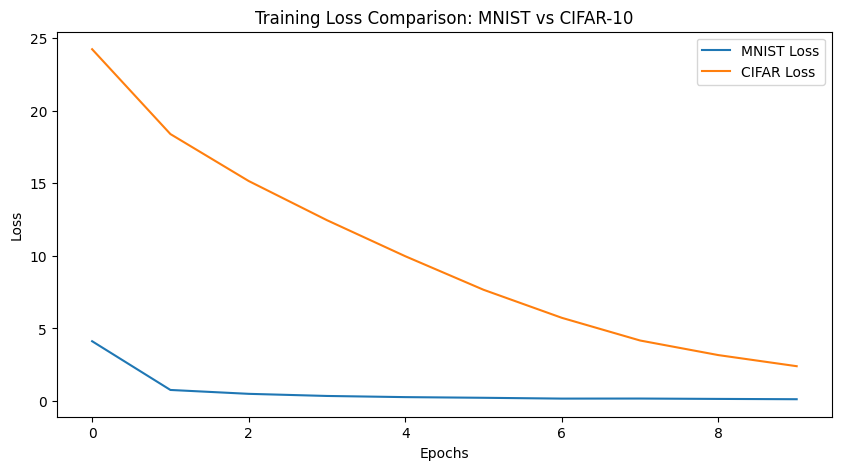

In [16]:

# Plot loss curves
plt.figure(figsize=(10, 5))
for dataset in datasets:
    plt.plot(results[dataset]["losses"], label=f"{dataset} Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison: MNIST vs CIFAR-10")
plt.legend()
plt.show()

In [21]:

def test_model_cifar(model, loss_fn, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct, total, test_loss = 0, 0, 0.0

    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            embeddings, norms = model(images)

            # Prediction and loss computation
           # predicted = outputs.argmax(dim=1)

            loss = loss_fn(embeddings, norms, labels)  # Get only the loss value
            test_loss += loss.mean().item()

    avg_test_loss = test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss
train_loader, test_loader = load_dataset("CIFAR")

model_cifar = SimpleCNN(embedding_size=512, input_channel = 3).to(device)
criterion = AdaFace(embedding_size=512, classnum=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_model_cifar(model_cifar, criterion, test_loader)


Test Loss: -3.0126


-3.012614745128004